In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

Importamos la lista de palabras [LabMT](http://neuro.imm.dtu.dk/wiki/LabMT) para sentiment analysis.

In [6]:
url = 'http://www.plosone.org/article/fetchSingleRepresentation.action?uri=info:doi/10.1371/journal.pone.0026752.s001'
labmt = pd.read_csv(url, skiprows=2, sep='\t', index_col=0) 

In [7]:
average   = labmt.happiness_average.mean()
happiness = (labmt.happiness_average - average).to_dict()

Le decimos a `PlaintextCorpusReader` cómo tiene que segmentar las palabras.

In [280]:
from nltk.corpus import PlaintextCorpusReader

pattern = r'''(?x)    # verbose regexps
      \d+[.:]\d+      # horas y números con decimales
    | mgs?\.          # abreviaturas comunes
    | \w+\.(?:\w+\.)+ # acrónimos
    | \w+             # palabras alfanuméricas
    | [^\w\s]+        # signos de puntuación
'''

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(pattern)

Cargamos un corpus de Erowid.

In [281]:
import os, glob

archivos = [os.path.basename(file) for file in glob.glob('corpus/utf8_*.txt')]
corpus   = PlaintextCorpusReader('corpus', archivos, word_tokenizer=tokenizer)

In [282]:
print('cantidad de experiencias', len(archivos))

cantidad de experiencias 1197


Calculamos la felicidad de las oraciones de cada experiencia.

In [283]:
felicidad_oraciones = {}

for experiencia in archivos:
    s = []
    
    for oración in corpus.sents(experiencia):
        s.append(
            sum([happiness.get(palabra.lower(), 0.0) for palabra in oración]) / len(oración)
        )
        
    felicidad_oraciones[experiencia] = pd.Series(s)

Calculamos la felicidad de cada experiencia promediando la felicidad de sus oraciones.

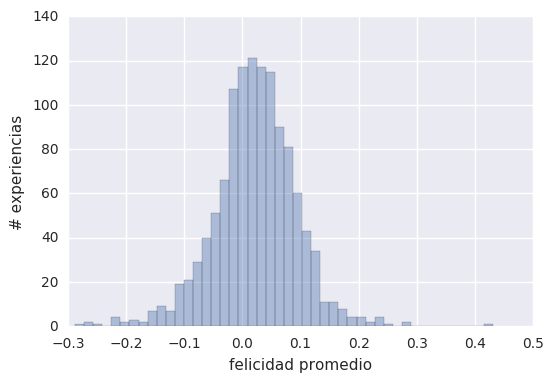

In [284]:
felicidad_experiencias = list(map(np.mean, felicidad_oraciones.values()))
sn.distplot(felicidad_experiencias, kde=False)
plt.ylabel('# experiencias')
plt.xlabel('felicidad promedio');

Queremos calcular la evolución de la felicidad oración a oración. Antes queremos ver cómo se distribuye la longitud de las experiencies medida en cantidad de oraciones; para hacer que las experiencias sean comparables tenemos que normalizar su longitud.

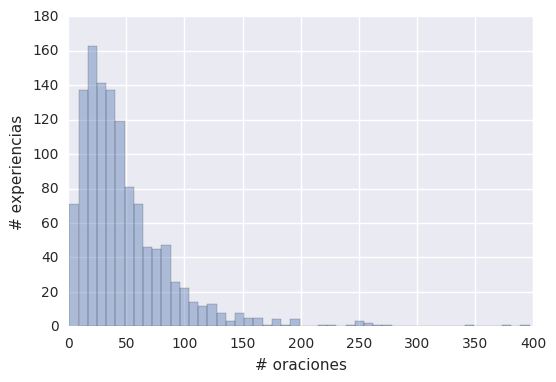

In [285]:
longitud_oraciones = list(map(len, felicidad_oraciones.values()))
sn.distplot(longitud_oraciones, kde=False)
plt.ylabel('# experiencias')
plt.xlabel('# oraciones');

Viendo el histograma, la longitud de las experiencias podría ser 20 oraciones...

In [235]:
LONGITUD = 20

Revisamos algunas experiencias individualmente para entender un poco mejor con qué estamos trabajando.

In [262]:
def analizar_experiencia(experiencia):
    felicidad_oraciones[archivos[experiencia]].plot()
    plt.ylabel('felicidad')
    plt.xlabel('oración')

    for i, oración in enumerate(corpus.sents(archivos[experiencia])):
        print('%2d ' % i, ' '.join(oración))
        
    print('\n\nFELICIDAD', '%.2f' % felicidad_oraciones[archivos[experiencia]].mean())

 0  Well to start off I ' m about 6 ' 1 ' and weigh about 165 lb ' s .
 1  The day started by being boring since my friends were gone .
 2  I decided to go to my local Grocery store and try and find some over - the - counter herbs .
 3  I started by looking at ephedrine .
 4  But I have heard many people die from this drug .
 5  I came across this bottle labeled Kava - Kava Root .
 6  I have heard that it relaxes people and so I went to buy it .
 7  So I went to my home and up to my room .
 8  It was around 11:00 PM and my mom was asleep so I decided this is the best time for it .
 9  But I had to set some things up first .
10  Before I do any kind of drug by myself I have to set up my room properly .
11  I turned on my lava lamp .
12  Then put on my Hypnogenic screensaver .
13  Turned off all the lights and put on my water fountain ( calms me down a lot :)).
14  11:20 PM : I took two capsules .
15  11:50 PM : A slightly calm feeling fell over my body .
16  12:10 PM : I decided to take

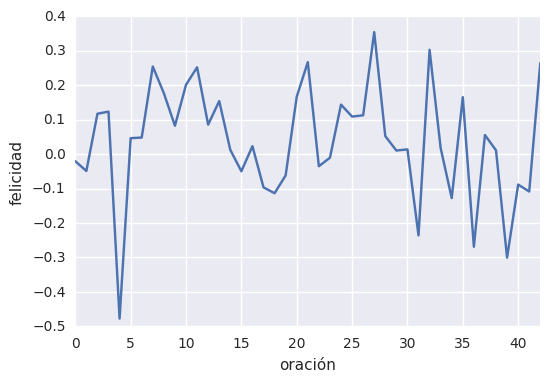

In [263]:
analizar_experiencia(30)

 0  I had tried coke twice before w / no effect , but I ' ll tell you about my third ( and first successful ) experience .
 1  It was only last week actually .
 2  Where I work , mostly people smoke weed , but I found out recently that coke was going around .
 3  After being invited to try it the fist time and then getting some from a friend the second time , I thought that perhaps it just wasn ' t my drug of choice ( pot btw ).
 4  A coworker started to sell it ; so , I thought w / it now being really close by , I would try again .
 5  I bought a 20 bag and waited for a slow period .
 6  When the others were taking a smoke break , I decided to take my break to the car .
 7  I emptied the bag and began to cut it .
 8  Now I went against my normal smart advice and didn ' t do much research about coke .
 9  I know a few people whose drug of choice is coke , but I stupidly didn ' t ask them too much .
10  So , I just separated it into two fat lines .
11  I rolled up a dollar and took them

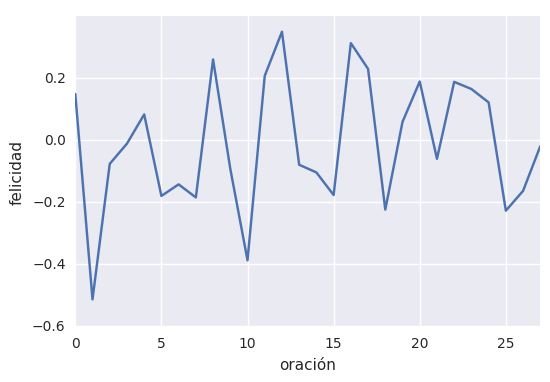

In [292]:
analizar_experiencia(1111)

 0  Meth has become my beautiful white snow , and this is my story , it being both good and bad , of my experiences with methamphetamine .
 1  I am a shift worker , at a gas station , while I work through college .
 2  I don ' t need the job , I like the extra income , and the satisfaction of not relying on my family and friends for my needs .
 3  Shift working is hard .
 4  Hours can be unpredictable at best , and hours are long .
 5  ( I ' ve worked 28 hours straight )
 6  I used ephedra , Xenadrine and other diet drugs to keep me up and working , but I grew very tolerant to it , and I required nearly three times the dose to get the same effects .
 7  Still , when a friend of mine recomended methamphetamine , I didn ' t like the idea , seeing as I live in an area known as ' Felony Flats ', all I ' ve heard are the awful conditions of some meth labs , small children with chemical burns and other sad stories .
 8  I gave in , and tryed a line .
 9  It was amazing .
10  Suddenly , navig

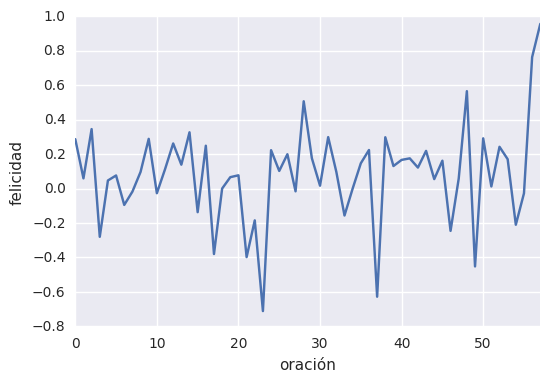

In [294]:
analizar_experiencia(140)

Practicamos una manera de normalizar la extensión de las experiencias y comparamos el antes y el después con algunas. 

In [484]:
def subsample(felicidad_oración):
    suavizado = \
        felicidad_oración \
        .rolling(5, center=True).mean() \
        .dropna().reset_index(drop=True)
    
    muestreado = \
        suavizado[ sorted(np.random.choice( range( len(suavizado) ), size=LONGITUD, replace=False)) ] \
        .reset_index(drop=True)
        
    return muestreado

In [482]:
def analizar_subsample(experiencia):
    felicidad_oración = felicidad_oraciones[archivos[experiencia]]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,3))
    ax1.set_ylim(-0.8,0.8)
    felicidad_oración.plot(ax=ax1)
    subsample(felicidad_oración).plot(ax=ax2);

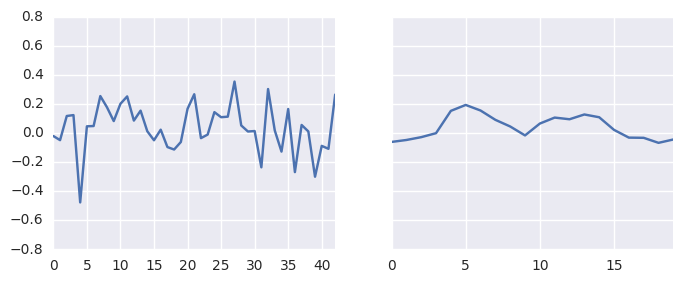

In [486]:
analizar_subsample(30)

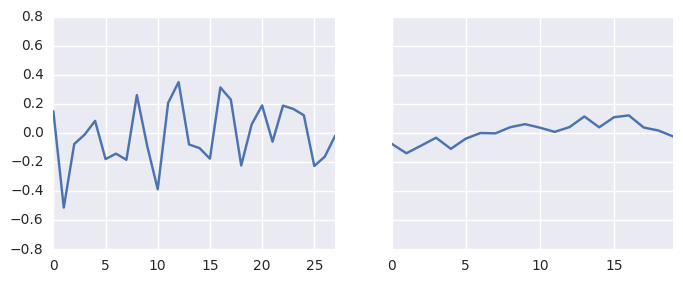

In [487]:
analizar_subsample(1111)

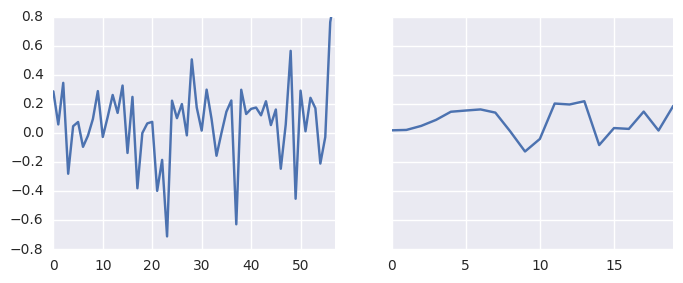

In [488]:
analizar_subsample(140)

Preparamos las muestras para aplicar SVD. Cada columna es una experiencia, cada fila una oración, así podemos reducir la cantidad de experiencias a cierto número reducido de experiencias paradigmáticas.

In [508]:
felicidad_oraciones_normalizada = {k:subsample(v) for k,v in felicidad_oraciones.items() if len(v) > LONGITUD + 3}
felicidad_oraciones_normalizada = pd.DataFrame(felicidad_oraciones_normalizada)

In [518]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=6, n_iter=7, random_state=42)
paradigmas = pd.DataFrame(svd.fit_transform(felicidad_oraciones_normalizada))

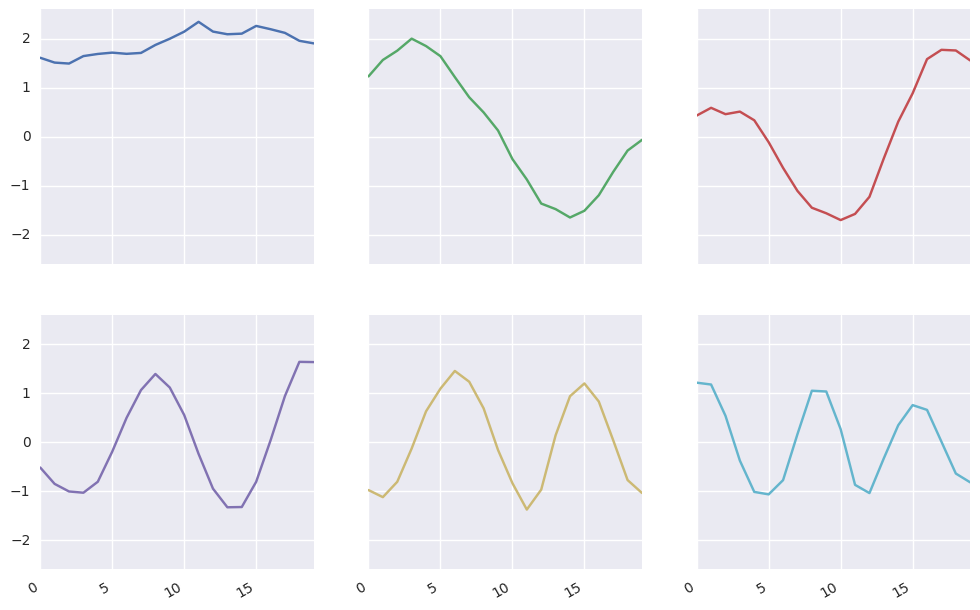

In [525]:
paradigmas.plot(subplots=True, layout=(2,3), sharey=True, ylim=(-2.6,2.6), figsize=(12,8), legend=False);

21/04/2018

Se está tokenizando didn't y otras abreviaciones como didn + t. Esto no está mal para LSA pero quizás sí afecte a SA.

http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization

In [2]:
ero = pd.read_pickle('enzo/data_erowid_final.p')

In [8]:
ero.head()

,droga,exp,raices
1948,Cannabis,15999,"[time, of, experience, age, occupation, cc, st..."
1959,Cannabis,76658,"[well, first, of, all, i, suppose, i, should, ..."
1961,Cannabis,52875,"[i, ve, always, be, relatively, lonely, but, t..."
1962,Cannabis,35827,"[the, following, report, be, write, to, provid..."
1963,Cannabis,55163,"[hello, my, name, be, daniel, and, i, would, l..."


In [9]:
ero.droga.unique()

array(['Cannabis', 'Salvia_divinorum', 'MDMA', 'LSD', 'DXM', 'Opiates',
       'Alcohol', 'Cocaine', 'Harmala_alkaloids', '2C-I', 'Morning_glory',
       'Amphetamines', 'DMT', 'Ketamine', 'Metamphetamine', '5-MeO-DMT',
       'NBOMe', 'H.B.Woodrose', '2C-E', 'SSRI', '5-MeO-DiPT',
       'Cacti_San_Pedro', 'Nutmeg', 'Kratom', 'Datura', 'Oxido_nitroso',
       'AMT', '2C-B', 'Difenhidramina', 'Tramadol', 'Oxicodona', '2C-T-7',
       'Cafeina', 'Heroina', 'Ayahuasca', 'Hidrocodona_vicodin', 'DPT',
       'Amanitas', 'Dimenhidrinato', 'Zolpidem_ambien', 'Kava', 'GHB',
       'Metoxetamina', 'Codeina', 'Cannabinoid_Receptor_Agonists',
       '2C-T-2', 'Alprazolam_xanax', 'Alcohol_hard', 'Tabaco',
       'Mimosahuasca', 'AB-FUBINACA', 'Metilfenidato',
       'Cannabis_sintetico', 'Alcohol_Beer_Wine', 'Metilona',
       'Bupropion_wellbutrin', 'Buprenorfina', '4-AcO-DMT',
       'Venlafaxina_effexor', 'Modafinilo', '5-MeO-AMT',
       'Paroxetina_paxil', 'Anadenanthera_colubrina', 'MDA', 'M

In [84]:
for i, experiencia in ero.iterrows():
    felicidad_palabras = pd.Series([happiness.get(palabra, 0.0) for palabra in experiencia.raices])
    ero.at[i, 'raices'] = felicidad_palabras
    ero.loc[i, 'felicidad'] = felicidad_palabras.mean()

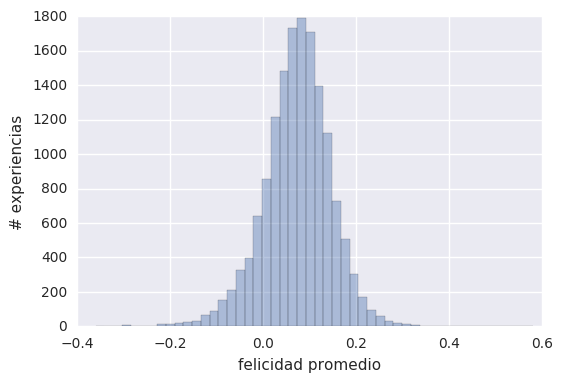

In [14]:
sn.distplot(ero.felicidad, kde=False)
plt.ylabel('# experiencias')
plt.xlabel('felicidad promedio');

In [36]:
felicidad_droga = ero.groupby('droga').felicidad.mean().to_frame().reset_index().sort_values('felicidad')

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


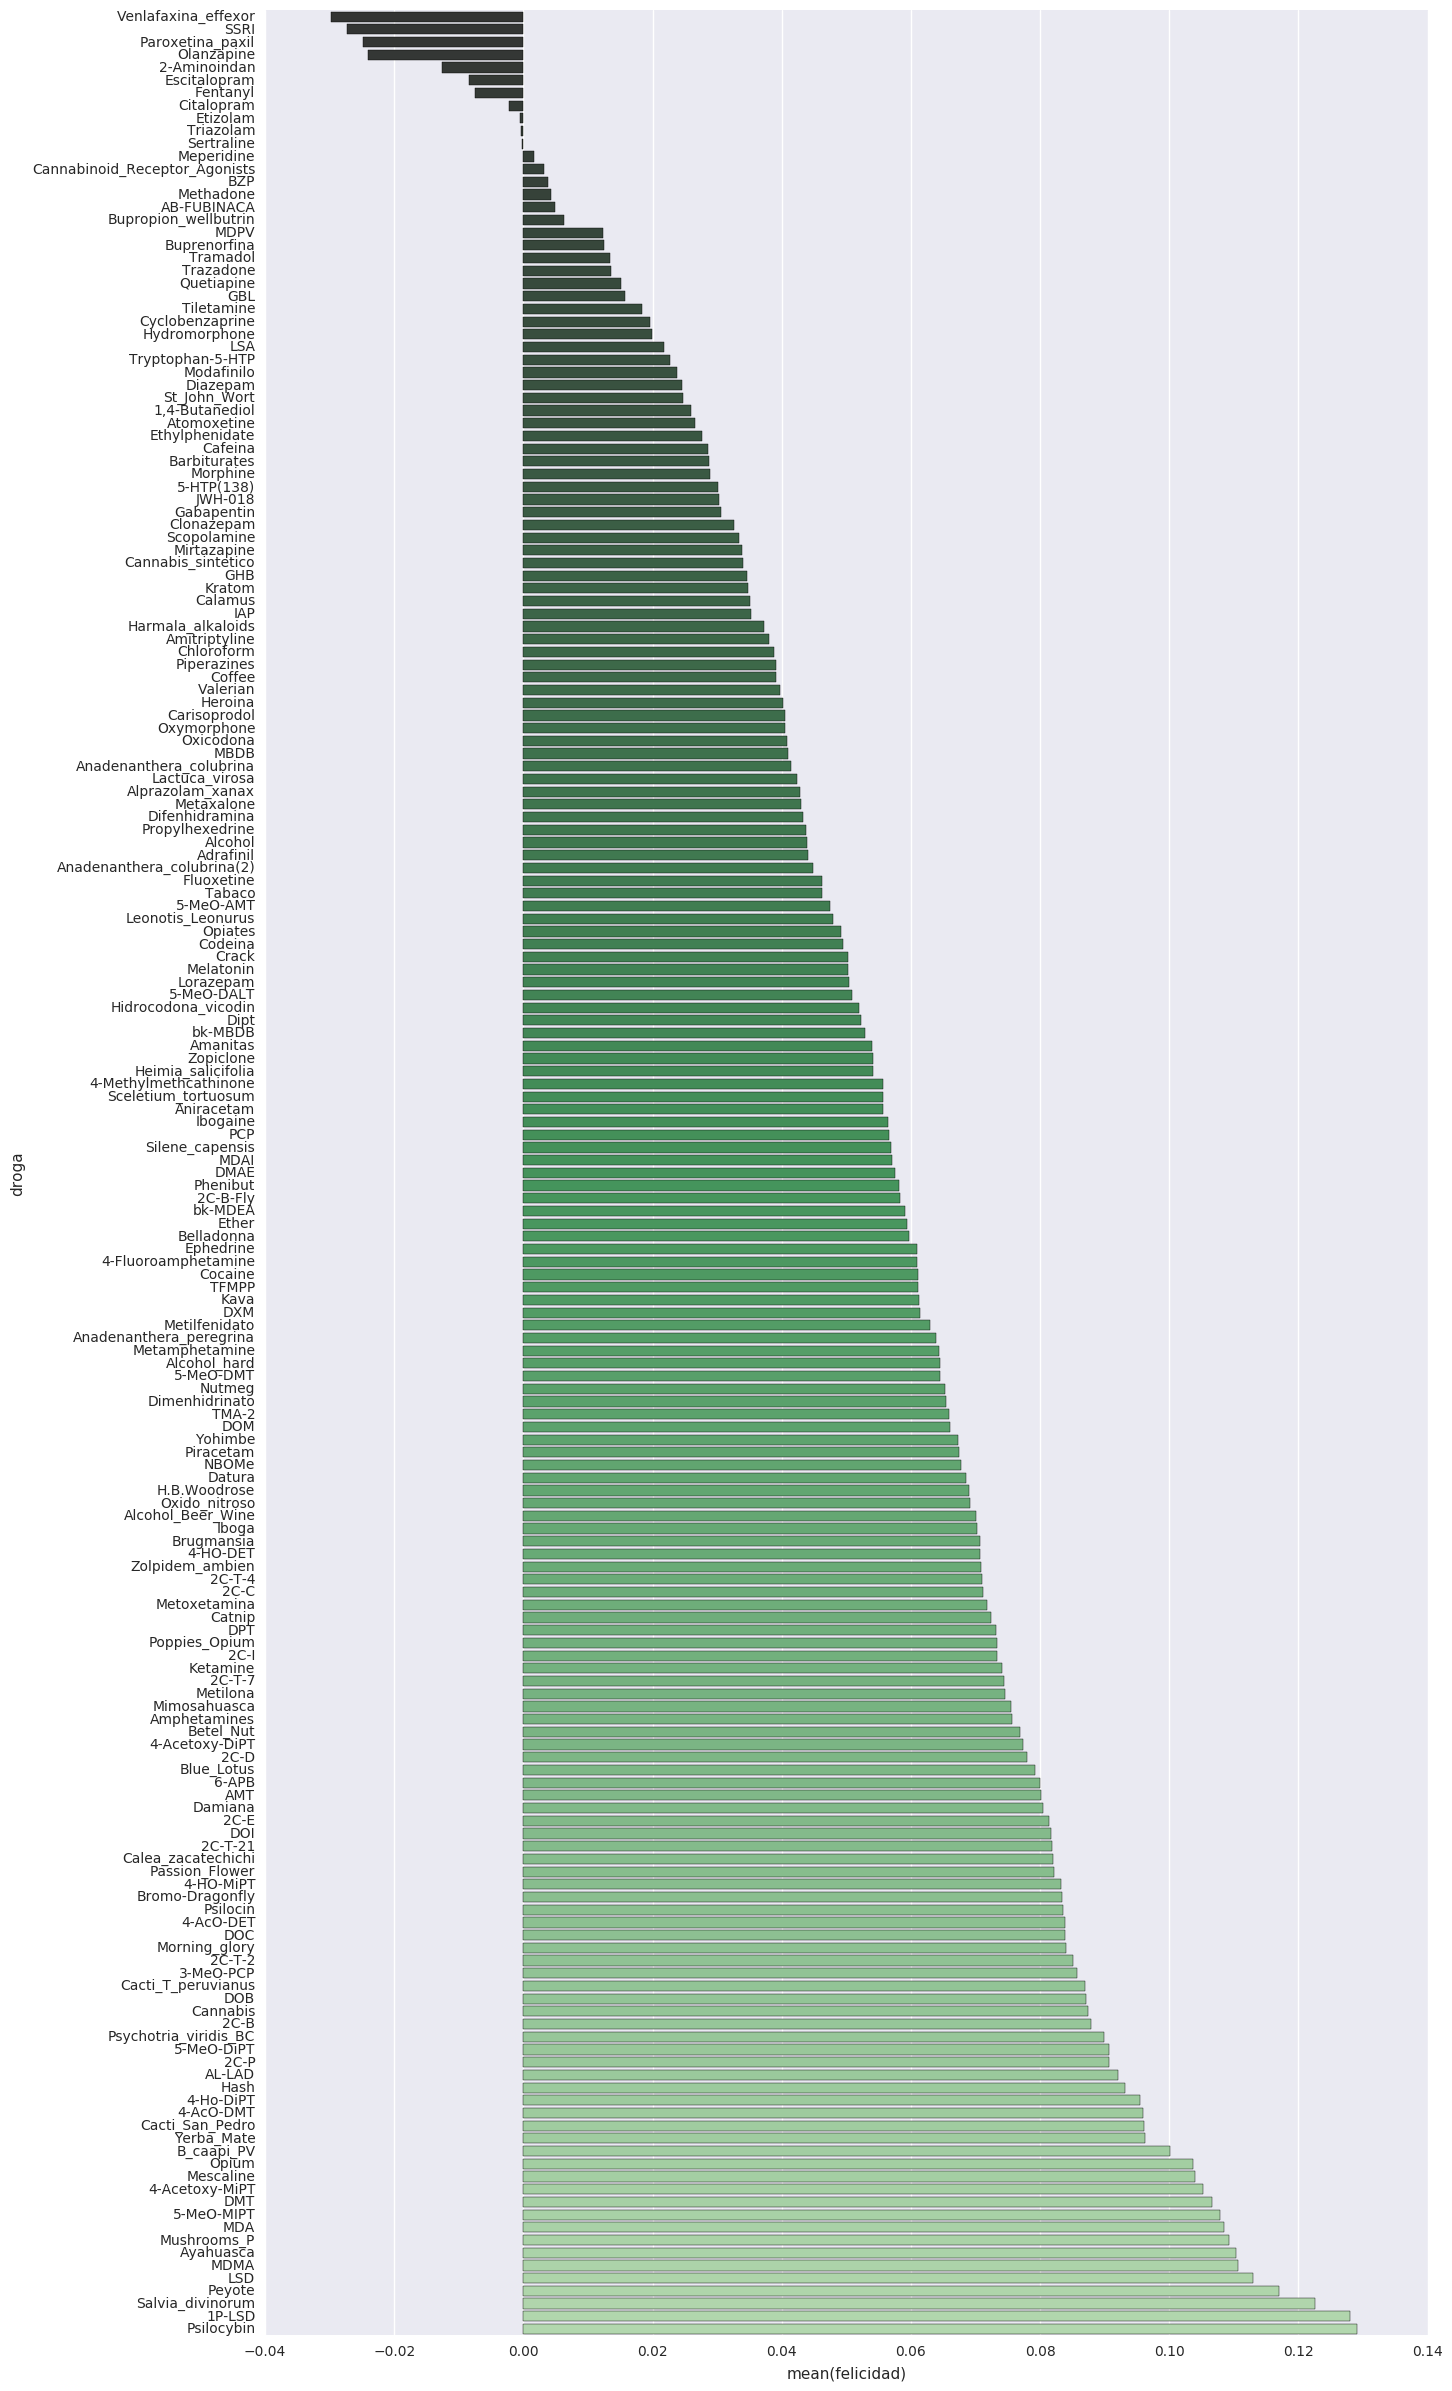

In [44]:
fig, ax = plt.subplots(figsize=(15,30))
sn.barplot(ax=ax, data=felicidad_droga, y='droga', x='felicidad', palette="Greens_d");

In [53]:
categorías = {
    1 : 'Psychedelic (other)',
    2 : 'Psychedelic (serotonergic)',
    3 : 'Psychedelic (entactogen)',
    4 : 'Psychedelic (dissociative)',
    5 : 'Depressant/sedative',
    6 : 'Stimulant',
    7 : 'Delirant',
    8 : 'MAOI',
    9 : 'Antipsychotic/antidepressant',
    10: 'Oneirogen',
}

In [48]:
clasificación = pd.read_csv('enzo/clasificación_drogas.csv', header=None, names=['droga', 'principal', 'secundaria'])

In [55]:
clasificación.principal  = clasificación.principal.apply(lambda x: categorías[x])
clasificación.secundaria = clasificación.secundaria.apply(lambda x: categorías[x])

In [62]:
clasificación.droga = clasificación.droga.str.strip()

In [66]:
ero_categorías = pd.merge(ero, clasificación, on='droga')

In [69]:
felicidad_categorías = ero_categorías.groupby('principal').felicidad.mean().to_frame().reset_index().sort_values('felicidad')

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


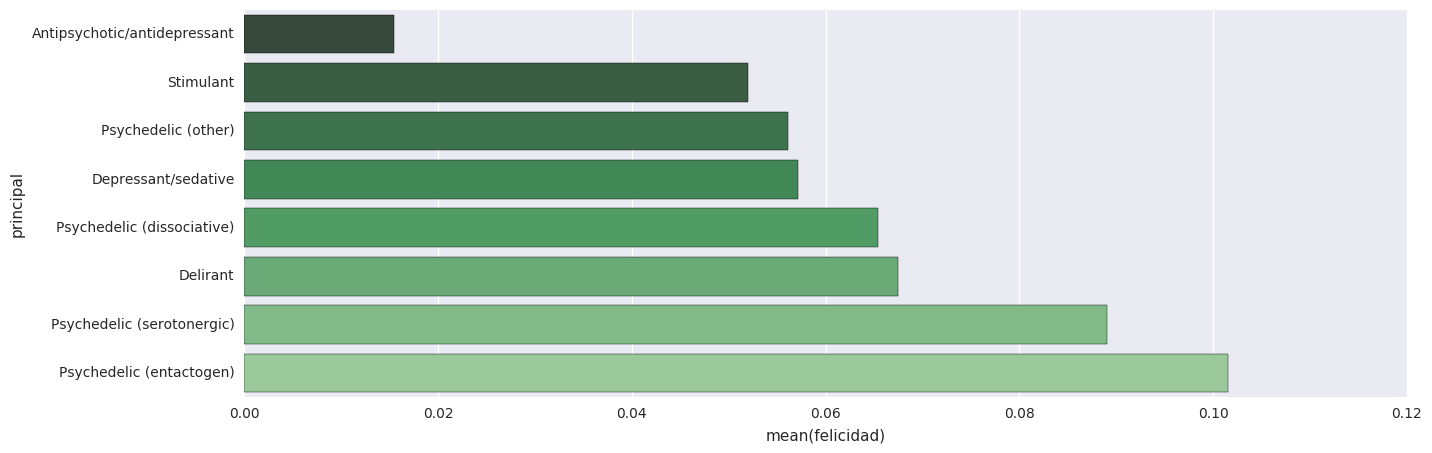

In [73]:
fig, ax = plt.subplots(figsize=(15,5))
sn.barplot(ax=ax, data=felicidad_categorías, y='principal', x='felicidad', palette="Greens_d");

/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/home/matias/.pyenv/versions/3.5.2/lib/python3.5/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


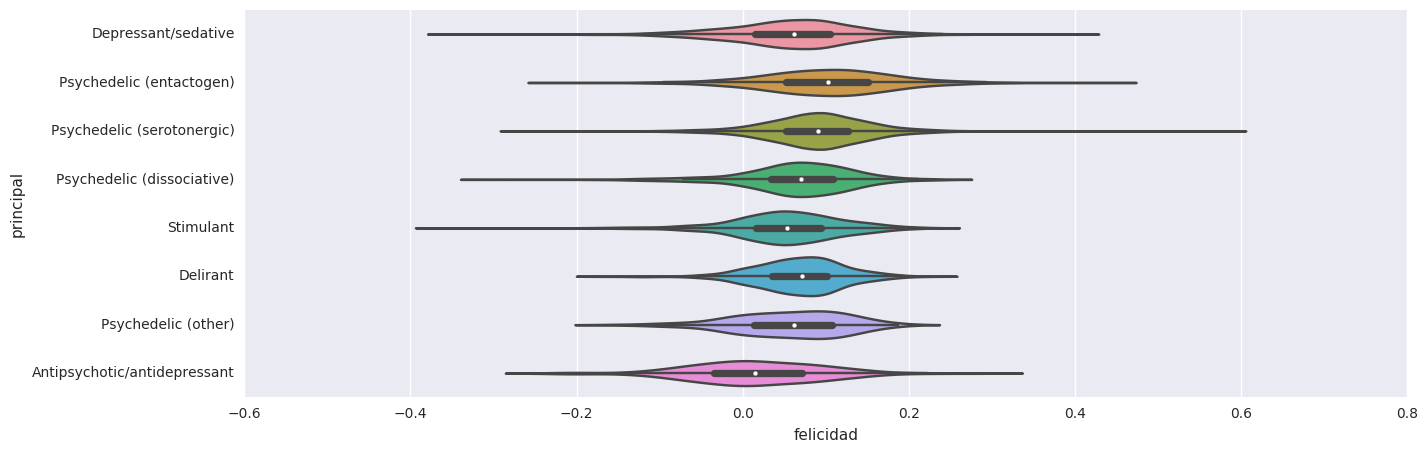

In [94]:
fig, ax = plt.subplots(figsize=(15,5))
sn.violinplot(x='felicidad', y='principal', data=ero_categorías);

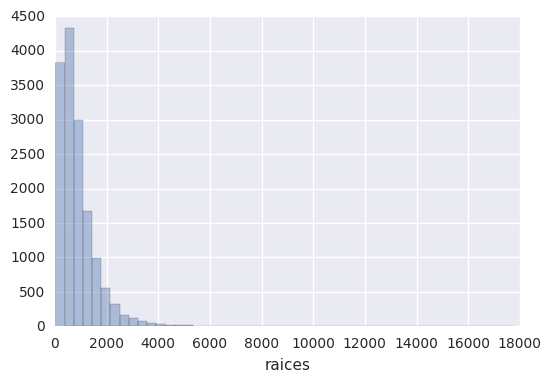

In [92]:
sn.distplot(ero.raices.apply(len), kde=False);

### TODO

* filtrar palabras que no están en el diccionario
* quitar las palabras que refieren a drogas porque pueden estar sesgadas
* binarizar por símbolos
* varianza, violinplot